# Homework7 Geometric Problems

In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
from matplotlib import pyplot as plt

## Three-way linear classification
Given three sets of data $x^{(1)}, x^{(2)}, \ldots, x^{(N)}$, $y^{(1)}, y^{(2)}, \ldots, y^{(M)}$, $z^{(1)}, z^{(2)}, \ldots, z^{(P)}$, 
find 3 affine function $f_i(x) = a_i^Tx - b_i (i = 1,2,3)$  
that satisfy the properties:  
for any $j$
1. $f_1(x^{(j)}) > max\{f_2(x^{(j)}), f_3(x^{(j)})\}$
2. $f_2(y^{(j)}) > max\{f_1(y^{(j)}), f_3(y^{(j)})\}$
3. $f_3(z^{(j)}) > max\{f_1(z^{(j)}), f_2(z^{(j)})\}$

In [2]:
# load data from MATLAB file

# attributes: M, N, P, X, Y, Z
data = loadmat("sep3way_data.mat")
M, N, P = data['M'][0, 0], data['N'][0, 0], data['P'][0, 0]  # 20
X = data['X']  # (2, 20)
Y = data['Y']  # (2, 20)
Z = data['Z']  # (2, 20)

### Remove strict inequalities
We can always scale $a_i$ and $b_i$ to satisfy:  
for any $j$
1. $f_1(x^{(j)}) \geq max\{f_2(x^{(j)}), f_3(x^{(j)})\} + 1$
2. $f_2(y^{(j)}) \geq max\{f_1(y^{(j)}), f_3(y^{(j)})\} + 1$
3. $f_3(z^{(j)}) \geq max\{f_1(z^{(j)}), f_2(z^{(j)})\} + 1$

In [3]:
a1, a2, a3 = cp.Variable(2), cp.Variable(2), cp.Variable(2)
b1, b2, b3 = cp.Variable(1), cp.Variable(1), cp.Variable(1)

# f1(x) = a1.T * x + b1, f1(x) > f1(y), f1(x) > f1(z)
cst = [a1 @ X - b1 - 1 >= cp.maximum(a2 @ X - b2, a3 @ X - b3),
       a2 @ Y - b2 - 1 >= cp.maximum(a1 @ Y - b1, a3 @ Y - b3),
       a3 @ Z - b3 - 1 >= cp.maximum(a1 @ Z - b1, a2 @ Z - b2)]

obj = cp.Minimize(0)
prob = cp.Problem(objective=obj, constraints=cst)
prob.solve()
# optimal -> all classified, infeasible -> partly misclassified
print(prob.status)

a1, a2, a3 = a1.value, a2.value, a3.value
b1, b2, b3 = b1.value, b2.value, b3.value
print("a1 = %s, \ta2 = %s, \ta3 = %s" % (a1, a2, a3))
print("b2 = %.4f, \tb2 = %.4f, \tb3 = %.4f" % (b1, b2, b3))

optimal
a1 = [3.22246572 1.8266569 ], 	a2 = [-2.26303503  2.09928835], 	a3 = [-1.075752  -3.5710991]
b2 = 4.4768, 	b2 = -0.7290, 	b3 = 6.6987


### plot points and separating hyperplanes

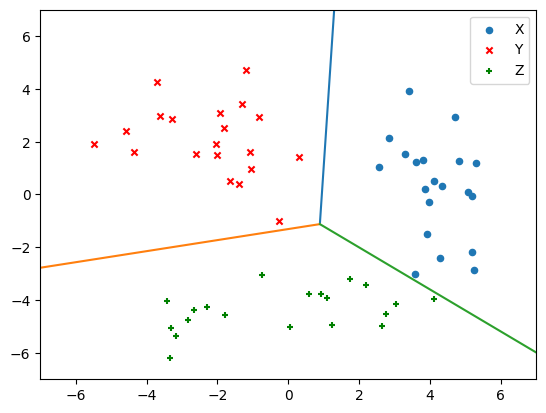

In [4]:
u1, v1 = a1 - a2, b1 - b2
u2, v2 = a2 - a3, b2 - b3
u3, v3 = a3 - a1, b3 - b1
t = np.linspace(-7 ,7, 1400)
line1 = (-u1[0]*t + v1)/u1[1]
idx1 = np.where(u2 @ np.array([t, line1]) - v2 > 0)
line2 = (-u2[0]*t + v2)/u2[1]
idx2 = np.where(u3 @ np.array([t, line2]) - v3 > 0)
line3 = (-u3[0]*t + v3)/u3[1]
idx3 = np.where(u1 @ np.array([t, line3]) - v1 > 0)

plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.plot(t[idx1], line1[idx1], t[idx2], line2[idx2], t[idx3], line3[idx3])
plt.scatter(X[0, :], X[1, :], 20, label='X')
plt.scatter(Y[0, :], Y[1, :], 20, c='r', marker='x', label='Y')
plt.scatter(Z[0, :], Z[1, :], 20, c='g', marker='+', label='Z')
plt.legend()
plt.show()
plt.close()

## Fitting sphere to data
Fit a sphere $\{x \in \textbf{R}^n | \|x-x_c\|_2 \leq r\}$ to $m$ points, $u_1,u_2,\ldots,u_m \in \textbf{R}^n$,  
which minimize
$$\sum_{i=1}^m(\|u_i-x_c\|_2^2 - r^2)^2$$

Define variable $x=(x_c,t)$, $A=[U, \textbf{1}]$, $b=(\|u_1\|_2^2, \|u_2\|_2^2, \ldots, \|u_m\|_2^2)$. ($t=r^2 - \|x_c\|_2^2$)  
The problem is converted into LS problem:
$$\text{minimize }\quad \|Ax-b\|_2^2$$
$$\text{subject to } \quad t \leq \|x_c\|_2^2$$

According to [solution](https://courses.edx.org/assets/courseware/v1/0e2d73c4bdf11d323bf2f8c954b3e4c4/asset-v1:StanfordOnline+SOE-YCVX0001+1T2020+type@asset+block/hw6sol.pdf), the optimal condition $A^T(Ax-b)=0$ guarantees the inequality constraint. Therefore, we can just solve the unconstrained LS problem.

In [5]:
U = loadmat("sphere_fitting_data.mat")['U']     # 2x50
n = U.shape[1]

x = cp.Variable((3, 1))
A = np.concatenate((2 * U.T, np.ones((n, 1))), axis=1)
b = np.sum(np.square(U.T), axis=1).reshape((n, 1))
print(b.shape)

obj = cp.Minimize(cp.sum_squares(A @ x - b))
prob = cp.Problem(obj, [])
prob.solve()

print("\nCheck whether (t + |x_c|^2 == r^2 >= 0)?")
print("---------------")
x_c, t = x.value[:-1], x.value[-1]
r2 = t + x_c.T @ x_c
if r2 >= 0:
    print("No problem! MSE is %.3f" % prob.value)
    print("r = %.3f" % np.sqrt(r2))
else:
    print("Oops! The direct method is infeasible.")
print("---------------")

(50, 1)

Check whether (t + |x_c|^2 == r^2 >= 0)?
---------------
No problem! MSE is 0.557
r = 1.305
---------------


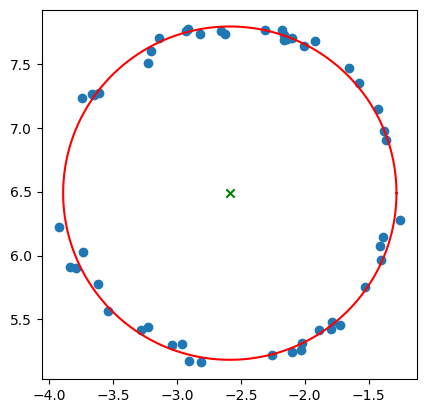

In [6]:
# plot the circle
plt.axes().set_aspect('equal')
plt.scatter(U[0, :], U[1, :], marker='o')
plt.scatter([x_c[0]], [[x_c[1]]], marker='x', color='g')
points = np.zeros((1000, 2))
for i, theta in enumerate(np.linspace(0, 2 * np.pi, 1000)):
    points[i] = x_c.reshape((2, )) + np.sqrt(r2) * np.array([np.cos(theta), np.sin(theta)])
plt.plot(points[:, 0], points[:, 1], 'r')
plt.show()

## Learning a quadratic pseudo-metric from distance measurements
$$\text{minimize } \frac{1}{N}\sum_{i=1}^{N}d_i^2-2d_i((x_i-y_i)^TP(x_i-y_i))^{\frac{1}{2}} + (x_i-y_i)^TP(x_i-y_i)$$
$$\text{subject to } P \succeq 0 $$

In [7]:
data = loadmat("quad_metric_data.mat")
d, d_test = data['d'], data['d_test']
n, N, N_test = data['n'][0, 0], data['N'][0, 0], data['N_test'][0, 0]
X, Y = data['X'], data['Y']
X_test, Y_test = data['X_test'], data['Y_test']

In [8]:
P = cp.Variable((n, n), symmetric=True)
temp = cp.quad_form(X - Y, P)
obj = cp.Minimize(cp.sum_squares(d) - 2 * d @ cp.sqrt(cp.diag(temp)) + cp.trace(temp))
prob = cp.Problem(obj, [P >> 0])

val = prob.solve() / N
print("optimal MSE: \t%.3f" % val)

temp = (X_test - Y_test).T @ P.value @ (X_test - Y_test)
test_val = np.sum(np.square(d_test)) - 2 * d_test @ np.sqrt(np.diag(temp)) + np.trace(temp)
test_val /= N_test
print("test MSE: \t%.3f" % test_val)

optimal MSE: 	0.887
test MSE: 	0.826


## Maximum volume rectangle inside a polyhedron
Find the max volome of rantangle $R = \{x \in \textbf{R}^n|l \preceq x \preceq u\}$ that enclosed in the hyperhedron $P=\{x | Ax \preceq b\}$, where $u$ and $v$ are variables.

### Naive idea
$R$ is inside $P$ iff all vertices $\langle\{l_i, u_i\}^n\rangle \in P$. The number of constraints is $2^n$, which is inefficient.

### Reduce constraints to $n$
for every i, we have $\sup_{l \preceq x \preceq u} a_i^Tx \leq b_i$  
The maximum value of lhs is when $A_{ij} \geq 0$, we select $x_j=u_j$; otherwise we select $x_j=l_j$.  
The compact form:
$$ \sum_{j=1}^{n} \max\{A_{ij},0\}u_j - \max\{-A_{ij},0\}l_j \leq b_i $$
So the problems have $n$ constraints that are affine for $u$ and $l$.

In [9]:
data = loadmat("max_vol_box_data.mat")
m, n = data['m'][0, 0], data['n'][0, 0]
A, b = data['A'], data['b'][:, 0]  # A:mxn, b:mx1

u = cp.Variable(n)
l = cp.Variable(n)
A_pos = np.maximum(A, 0)
A_neg = np.maximum(-A, 0)
constraints = [A_pos @ u - A_neg @ l <= b, l <= u]
obj = cp.Maximize(cp.geo_mean(u - l))

prob = cp.Problem(obj, constraints)
val = prob.solve()
print("Geometric Mean: \t%.3f" % val)

Geometric Mean: 	22.276


*Given answer: 1.18*  
Why?